# Experiments on detection and classification of prototypical and spontaneous fallacies in Spanish 

Please, refer to https://github.com/ITALIC-US/FallacyES for details.

All results have been obtained by setting the random seed to the value 42 for reproducibility. Results may vary if the versions of the dependencies in the runtime environment change. The dependencies used for the run for which the results are shown are as follows:

In [1]:
import pkg_resources

dependencias_experimentos = ['pandas', 'scikit-learn', 'numpy', 'matplotlib', 'transformers', 'datasets']

def obtener_dependencias(paquetes):
    dependencias = set(paquetes)
    dependencias_totales = set(paquetes)
    
    while dependencias:
        paquete = dependencias.pop()
        nuevas_dependencias = obtener_dependencias_directas(paquete)
        dependencias_totales |= nuevas_dependencias
        dependencias |= nuevas_dependencias - dependencias_totales
    
    return list(dependencias_totales)

def obtener_dependencias_directas(paquete):
    dependencias = set()
    for requerimiento in pkg_resources.require(paquete):
        dependencias.add(requerimiento.key)
    return dependencias


def obtener_versiones_instaladas(dependencias):
    versiones_instaladas = {}
    for dependencia in dependencias:
        version = obtener_version_instalada(dependencia)
        versiones_instaladas[dependencia] = version
    return versiones_instaladas

def obtener_version_instalada(dependencia):
    try:
        paquete = pkg_resources.get_distribution(dependencia)
        return paquete.version
    except pkg_resources.DistributionNotFound:
        return "No instalado"



lista_dependencias = obtener_dependencias(dependencias_experimentos)
versiones = obtener_versiones_instaladas(lista_dependencias)

for dependencia, version in versiones.items():
    print(dependencia, ":", version)

idna : 3.4
pyyaml : 6.0
dill : 0.3.6
requests : 2.28.2
xxhash : 3.2.0
aiohttp : 3.8.3
cycler : 0.11.0
fsspec : 2023.1.0
pytz : 2022.7.1
pandas : 1.5.3
colorama : 0.4.6
attrs : 22.2.0
fonttools : 4.38.0
frozenlist : 1.3.3
multidict : 6.0.4
async-timeout : 4.0.2
regex : 2022.10.31
transformers : 4.26.0
charset-normalizer : 2.1.1
threadpoolctl : 3.1.0
pillow : 9.4.0
certifi : 2022.12.7
tokenizers : 0.13.2
packaging : 23.0
datasets : 2.9.0
numpy : 1.23.5
joblib : 1.2.0
contourpy : 1.0.7
kiwisolver : 1.4.4
six : 1.16.0
tqdm : 4.64.1
scipy : 1.10.0
multiprocess : 0.70.14
yarl : 1.8.2
pyparsing : 3.0.9
responses : 0.18.0
scikit-learn : 1.2.1
matplotlib : 3.6.3
filelock : 3.9.0
aiosignal : 1.3.1
urllib3 : 1.26.14
typing-extensions : 4.4.0
pyarrow : 11.0.0
huggingface-hub : 0.12.0
python-dateutil : 2.8.2


## Datasets 

In [2]:
import pandas as pd

# Clasification

p12_df = pd.read_csv("datasets/fallacyES-prototypical.csv")
p12_df = p12_df.rename(columns={"fallacy_example": "text"})

p8_df = p12_df[~p12_df['label'].isin(['false causality', 'circular reasoning', 'intentional', 'equivocation', 'fallacy of relevance'])]

e8_df = pd.read_csv("datasets/fallacyES-spontaneous.csv")
e8_df = e8_df[e8_df["label"]!="non-fallacy"]

e5_df = e8_df[~e8_df['label'].isin(['appeal to emotion', 'faulty generalization', 'deductive fallacy'])]

In [3]:
# Detection (P)

counts_total = p12_df["label"].value_counts()
counts_no_falacias = p12_df.dropna(subset=["non-fallacy_example"])["label"].value_counts()

p_df = pd.DataFrame(columns=["text", "label"])
index = 0
for tipo, conteo in counts_total.items():
    if tipo in counts_no_falacias:
        if counts_no_falacias[tipo] <= conteo//2:
            num_seleccionadas = counts_no_falacias[tipo]
        else:
            num_seleccionadas = conteo//2 
        
        selected_rows = p12_df[(p12_df['label'] == tipo) & ~p12_df['non-fallacy_example'].isnull()].sample(n=num_seleccionadas, random_state=42)
        second_selected_rows = p12_df[(p12_df['label'] == tipo)].drop(selected_rows.index).sample(n=num_seleccionadas, random_state=42)
    
        for _, row in selected_rows.iterrows():
            p_df.loc[index] = [row["non-fallacy_example"], "no falacia"]
            index += 1
        for _, row in second_selected_rows.iterrows():
            p_df.loc[index] = [row["text"], "falacia"]
            index += 1                                               
 
p_df["label"].value_counts()

no falacia    942
falacia       942
Name: label, dtype: int64

In [4]:
# Detection (E)
e_df = pd.read_csv("datasets/fallacyES-spontaneous.csv")[["label","text"]]
e_df.loc[e_df["label"]!="non-fallacy", 'label'] = "falacia"
e_df.loc[e_df["label"]=="non-fallacy", 'label'] = "no falacia"

e_df["label"].value_counts()

falacia       923
no falacia    917
Name: label, dtype: int64

---
## Baseline (Logistic Regression)

In [5]:
# P12, P8, E8, E5, P, E (LR)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def baseline(df, evaluation="weighted", class_column = "label", text_column = "text", pos_class=""):
    le = LabelEncoder()
    y = le.fit_transform(df[class_column])
    
    X = df[text_column] 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    if evaluation == "binary":
        pos_class, = np.where(le.classes_ == pos_class)[0]
        f1 = f1_score(y_test, y_pred, average="binary", pos_label=pos_class)
    else:
        f1 = f1_score(y_test, y_pred, average=evaluation)

    print(f"F1: {f1}")

print("P12 LR")
baseline(p12_df)

print("\nP8 LR")
baseline(p8_df)

print("\nE8 LR")
baseline(e8_df)

print("\nE5 LR")
baseline(e5_df)

print("\nP LR")
baseline(p_df, evaluation="binary", pos_class="falacia")

print("\nE LR")
baseline(e_df, evaluation="binary", pos_class="falacia")

P12 LR
F1: 0.3906621763798738

P8 LR
F1: 0.4311800799029902

E8 LR
F1: 0.35173574334864666

E5 LR
F1: 0.3965811965811966

P LR
F1: 0.8137254901960784

E LR
F1: 0.6626506024096385


In [6]:
# P8 -> E8 (LR)

le = LabelEncoder()
y_train = le.fit_transform(p8_df["label"])
y_test = le.fit_transform(e8_df["label"])
X_train = p8_df["text"]
X_test = e8_df["text"]

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculamos la precisión del modelo
f1 = f1_score(y_test, y_pred, average="weighted")

print("P8->E8 LR")
print(f"F1: {f1}")

P8->E8 LR
F1: 0.11734198651551826


In [7]:
# P -> E (LR)

le = LabelEncoder()
y_train = le.fit_transform(p_df["label"])
y_test = le.fit_transform(e_df["label"])
X_train = p_df["text"]
X_test = e_df["text"]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average="binary", pos_label=0)
print("P->E LR")
print(f"F1: {f1}")

P->E LR
F1: 0.6356727760393385


---
## Flan-T5

In [8]:
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

MAX_SOURCE_LENGTH = 512 
MAX_TARGET_LENGTH = 8 

def preprocess_function(sample, class_names, tokenizer, texto_column, tipo_column):#,padding="max_length"):
    inputs = ["Posible falacia: " + item for item in sample[texto_column]]
    model_inputs = tokenizer(inputs, max_length=MAX_SOURCE_LENGTH, truncation=True)   
    labels = tokenizer(text_target=[class_names[label_id] for label_id in sample[tipo_column]], max_length=MAX_TARGET_LENGTH, truncation=True)    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def compute_metrics(eval_pred, tokenizer, evaluation, pos_class):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)  
    if evaluation == "binary":
        f1 = f1_score(decoded_labels, decoded_preds, average="binary", pos_label=pos_class)
        p = precision_score(decoded_labels, decoded_preds, average="binary", pos_label=pos_class)
        r = recall_score(decoded_labels, decoded_preds, average="binary", pos_label=pos_class)
    else:
        f1 = f1_score(decoded_labels, decoded_preds, average=evaluation)
        p = precision_score(decoded_labels, decoded_preds, average=evaluation)
        r = recall_score(decoded_labels, decoded_preds, average=evaluation)
    return {"f1": f1, "P": p, "R": r}


def fine_tuning_FlanT5(df, exp_name, num_epochs, delimiter=";", texto_column = "text", tipo_column="label",
                       evaluation="weighted", pos_class=""):
    dataset = Dataset.from_pandas(df, split="train").class_encode_column(tipo_column)
    dataset = dataset.train_test_split(test_size=0.1, stratify_by_column=tipo_column, seed = 42)
    
    model_id="google/flan-t5-base"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    
    tokenized_dataset = dataset.map(lambda x:preprocess_function(x, dataset["train"].features[tipo_column].names, tokenizer, texto_column=texto_column, tipo_column=tipo_column), batched=True, remove_columns=[texto_column, tipo_column])
    data_collator = DataCollatorForSeq2Seq(tokenizer)
    repository_id = f"{model_id.split('/')[1]}-" + exp_name

    training_args = Seq2SeqTrainingArguments(
        output_dir=repository_id,
        per_device_train_batch_size=4, 
        per_device_eval_batch_size=4, 
        gradient_accumulation_steps=16, 
        learning_rate=3e-4,
        weight_decay=0.0, 
        adam_epsilon=1e-8,
        warmup_steps=0, 
        predict_with_generate=True,
        generation_max_length=MAX_TARGET_LENGTH,
        fp16=False,        
        num_train_epochs=num_epochs,
        logging_dir=f"{repository_id}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=10,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        data_collator=data_collator,
        compute_metrics=lambda x:compute_metrics(x,tokenizer, evaluation, pos_class),
    )
        
    transformers.enable_full_determinism(42)
    trainer.train()
    
    tokenized_dataset["test"].set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    preds_outputs = trainer.predict(tokenized_dataset["test"], max_length=MAX_TARGET_LENGTH)    
    return preds_outputs.metrics['test_f1'], preds_outputs, trainer

def plot_confusion_matrix(y_preds, y_true, labels, filename):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig(filename, format="pdf", bbox_inches="tight")

def experiment_confusion_matrix(preds_outputs, filename, model_id="google/flan-t5-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    pred_labels, true_labels = preds_outputs.predictions, preds_outputs.label_ids
    decoded_preds = tokenizer.batch_decode(pred_labels, skip_special_tokens=True)
    true_labels = np.where(true_labels != -100, true_labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(true_labels, skip_special_tokens=True)

    labels = set(decoded_labels)
    labels2 = set(decoded_preds)

    if len(labels2 - labels)>0:
        print("Unkown predicted labels (wrong tokenization?)")

    labels = sorted(labels)
    
    labels_es={
        'false dilemma': 'fd', 
        'deductive fallacy': 'de',
        'ad populum': 'ap',
        'fallacy of relevance': 'pf',
        'faulty generalization': 'ga',
        'false causality': 'fc',
        'ad hominem': 'ah',
        'circular reasoning': 'rc',
        'equivocation': 'e',
        'appeal to emotion': 'ae',
        'intentional': 'i',
        'fallacy of extension': 'hp',
        'fallacy of credibility': 'c'
    }
    
    labels_to_ids = {label:num for num, label in enumerate(labels)}

    decoded_labels_ids = [labels_to_ids[label] for label in decoded_preds]
    true_labels_ids = [labels_to_ids[label] for label in decoded_labels]

    plot_confusion_matrix(decoded_labels_ids, true_labels_ids,  [labels_es[label] for label in labels], filename)

Epoch,Training Loss,Validation Loss,F1,P,R
0,1.313900,0.516047,0.132061,0.146543,0.220096
1,0.538100,0.429031,0.269722,0.406656,0.334928
2,0.431000,0.364408,0.445754,0.508423,0.449761
3,0.333300,0.336405,0.504146,0.556595,0.511962
4,0.256500,0.326590,0.570881,0.587678,0.564593
5,0.198200,0.374781,0.552746,0.579743,0.559809
6,0.159400,0.412161,0.541657,0.564621,0.545455
7,0.122600,0.488078,0.559836,0.593588,0.555024
8,0.086500,0.567106,0.559608,0.573626,0.559809
9,0.064900,0.590399,0.580794,0.615439,0.578947


P12 FlanT5
F1: 0.6179470999921906


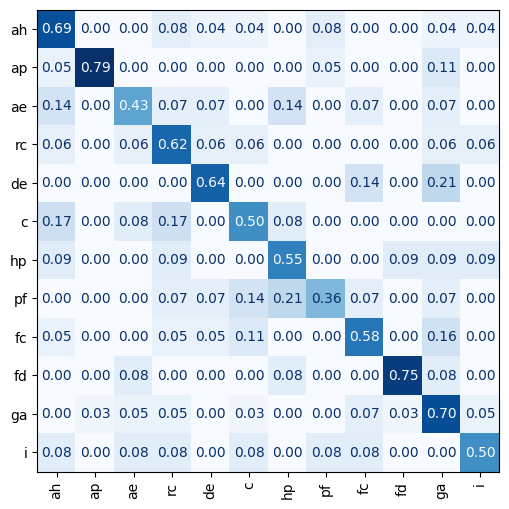

In [9]:
# P-12 (FlanT5)
f1, preds_outputs, _ = fine_tuning_FlanT5(p12_df, "P-12", 50, delimiter=",", texto_column="text", tipo_column="label")
experiment_confusion_matrix(preds_outputs, "confusion_matrix_P12.pdf")
print("P12 FlanT5")
print(f"F1: {f1}")

In [10]:
# P-8 (FlanT5)
f1, _, trainer_p8_flan = fine_tuning_FlanT5(p8_df, "P-8", 50, delimiter=",", texto_column="text", tipo_column="label")
print("P8 FlanT5")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
0,1.292800,0.410541,0.220814,0.186974,0.297297
1,0.433800,0.333235,0.372191,0.417644,0.452703
2,0.339600,0.250478,0.523807,0.564321,0.560811
3,0.259700,0.236093,0.600676,0.614949,0.614865
4,0.199400,0.202744,0.685310,0.692515,0.689189
5,0.143800,0.253810,0.620489,0.646963,0.621622
6,0.107500,0.278639,0.661161,0.672135,0.662162
7,0.084500,0.317602,0.658794,0.675985,0.668919
8,0.057100,0.344589,0.653022,0.663527,0.668919
9,0.045100,0.362579,0.643462,0.667315,0.648649


P8 FlanT5
F1: 0.7259322907024057


In [11]:
# P-8 -> E-8 (FlanT5)

dataset = Dataset.from_pandas(e8_df, split="train").class_encode_column("label")
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label", seed = 42)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
tokenized_dataset = dataset.map(lambda x:preprocess_function(x, 
                                                             dataset["train"].features["label"].names, 
                                                             tokenizer, 
                                                             texto_column="text", tipo_column="label"), 
                                batched=True, 
                                remove_columns=["text", "label"])


tokenized_dataset["test"].set_format("torch", columns=["input_ids", "attention_mask", "labels"])
preds_outputs = trainer_p8_flan.predict(tokenized_dataset["test"], max_length=MAX_TARGET_LENGTH)

print("P8->E8 FlanT5")
print(f"F1: {preds_outputs.metrics['test_f1']}")

P8->E8 FlanT5
F1: 0.31392953414850894


In [12]:
# E-8 (FlanT5)
f1, _, _ = fine_tuning_FlanT5(e8_df, "E-8", 50, delimiter=",", texto_column="text", tipo_column="label")
print("E8 FlanT5")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,1.800100,0.470466,0.217043,0.184297,0.290323
2,0.464300,0.382069,0.185702,0.136175,0.311828
3,0.390600,0.357068,0.294300,0.314270,0.387097
4,0.330800,0.300169,0.457332,0.434559,0.494624
5,0.275300,0.325000,0.477132,0.463853,0.516129
6,0.221500,0.344486,0.455461,0.568409,0.505376
7,0.163600,0.389450,0.526434,0.560770,0.559140
8,0.123800,0.392330,0.573337,0.570645,0.591398
9,0.084800,0.517810,0.476447,0.528592,0.505376
10,0.074300,0.449320,0.524928,0.506368,0.559140


E8 FlanT5
F1: 0.603916592984874


In [13]:
# E-5 (FlanT5)
f1, _, _ = fine_tuning_FlanT5(e5_df, "E-5", 50, delimiter=",", texto_column="text", tipo_column="label")
print("E5 FlanT5")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
0,1.750400,0.339984,0.168107,0.154103,0.275000
1,0.361900,0.274793,0.332467,0.364170,0.375000
2,0.285400,0.261638,0.446088,0.483625,0.512500
3,0.243500,0.255879,0.471179,0.574486,0.487500
4,0.186000,0.222742,0.588117,0.644339,0.600000
5,0.141600,0.230354,0.586479,0.674892,0.600000
6,0.097100,0.253892,0.618837,0.696653,0.637500
7,0.067800,0.324725,0.592340,0.688518,0.600000
8,0.054400,0.340599,0.630824,0.705811,0.637500
9,0.037300,0.335505,0.596667,0.604633,0.612500


E5 FlanT5
F1: 0.6575397877984084


In [14]:
# P (FlanT5)
f1, _, trainer_p_flan = fine_tuning_FlanT5(p_df, "P", 50, delimiter=",", texto_column="text", tipo_column="label", evaluation="binary", pos_class="falacia")
print("P FlanT5")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
0,0.418100,0.071824,0.871795,0.841584,0.904255
1,0.096600,0.069526,0.888889,0.930233,0.851064
2,0.071100,0.069800,0.886364,0.951220,0.829787
3,0.049100,0.065822,0.868571,0.938272,0.808511
4,0.031000,0.123951,0.790123,0.941176,0.680851
5,0.022900,0.072964,0.921466,0.907216,0.936170
6,0.013400,0.072410,0.929730,0.945055,0.914894
7,0.010400,0.103318,0.928962,0.955056,0.904255
8,0.005400,0.164372,0.878613,0.962025,0.808511
9,0.005100,0.148058,0.886364,0.951220,0.829787


P FlanT5
F1: 0.9297297297297297


In [15]:
# P -> E (FlanT5)

dataset = Dataset.from_pandas(e_df, split="train").class_encode_column("label")
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label", seed = 42)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
tokenized_dataset = dataset.map(lambda x:preprocess_function(x, 
                                                             dataset["train"].features["label"].names, 
                                                             tokenizer, 
                                                             texto_column="text", tipo_column="label"), 
                                batched=True, 
                                remove_columns=["text", "label"])


tokenized_dataset["test"].set_format("torch", columns=["input_ids", "attention_mask", "labels"])
preds_outputs = trainer_p_flan.predict(tokenized_dataset["test"], max_length=MAX_TARGET_LENGTH)

print("P->E FlanT5")
print(f"F1: {preds_outputs.metrics['test_f1']}")

P->E FlanT5
F1: 0.669811320754717


In [16]:
# E (FlanT5)
f1, _, _ = fine_tuning_FlanT5(e_df, "E", 50, delimiter=",", texto_column="text", tipo_column="label", evaluation="binary", pos_class="falacia")
print("E FlanT5")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
0,0.467100,0.157273,0.419355,0.812500,0.282609
1,0.138400,0.129956,0.684932,0.925926,0.543478
2,0.096200,0.109913,0.758242,0.766667,0.750000
3,0.060500,0.143565,0.745342,0.869565,0.652174
4,0.035100,0.172774,0.742138,0.880597,0.641304
5,0.030900,0.181490,0.776471,0.846154,0.717391
6,0.014700,0.252152,0.739884,0.790123,0.695652
7,0.012300,0.254573,0.748466,0.859155,0.663043
8,0.005800,0.311927,0.752941,0.820513,0.695652
9,0.009400,0.286696,0.754098,0.758242,0.750000


E FlanT5
F1: 0.7891891891891891


---
## RoBERTa-BNE

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import transformers
from datasets import Dataset

tokenizador = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne') 

def evalua_binary(p):    
    predicciones, etiquetas = p
    predicciones = np.argmax(predicciones, axis=1)
    f1 = f1_score(y_true=etiquetas, y_pred=predicciones, average="binary", pos_label=1)
    p = precision_score(y_true=etiquetas, y_pred=predicciones, average="binary", pos_label=1)
    r = recall_score(y_true=etiquetas, y_pred=predicciones, average="binary", pos_label=1)
    return {"f1": f1, "p": p, "r": r} 

def evalua_weighted(p):    
    predicciones, etiquetas = p
    predicciones = np.argmax(predicciones, axis=1)
    f1 = f1_score(y_true=etiquetas, y_pred=predicciones, average="weighted")
    p = precision_score(y_true=etiquetas, y_pred=predicciones, average="weighted")
    r = recall_score(y_true=etiquetas, y_pred=predicciones, average="weighted")
    return {"f1": f1, "p": p, "r": r} 


def plot_confusion_matrix(y_preds, y_true, labels, filename):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig(filename, format="pdf", bbox_inches="tight")


def dibuja_matriz_confusion(preds_outputs, labels, filename):
    pred_ids, true_ids = preds_outputs.predictions.argmax(axis=-1), preds_outputs.label_ids
    
    decoded_labels = [labels[i] for i in pred_ids]
    true_labels = [labels[i] for i in true_ids]

    plot_confusion_matrix(pred_ids, true_ids,  labels, filename)
    
def run(name,dataset, modelo, fun_evalua, matrix_filename=None, labels=None, epochs=10):
    # Aplicamos el tokenizador    
    def tokeniza(batch):
      return tokenizador(batch["text"], truncation=True) 
    dataset = dataset.map(tokeniza, batched=True)
    dataset.set_format("torch", 
                                columns=["input_ids", "attention_mask", "labels"])
    dataset = dataset.train_test_split(test_size=0.1, seed = 42)

    configuracion_train = TrainingArguments(output_dir = "output-" + name, 
        overwrite_output_dir  = True, 
        evaluation_strategy="epoch", 
        save_strategy="epoch",
        save_total_limit=10,
        load_best_model_at_end=True,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs, 
        metric_for_best_model="f1",
        logging_dir='./'+name+'logs',
        learning_rate=5e-5
    )

    trainer = Trainer(
        model=modelo,
        args=configuracion_train,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        compute_metrics=fun_evalua,
        data_collator = DataCollatorWithPadding(tokenizer=tokenizador) 
    )

    transformers.enable_full_determinism(42)
    trainer.train()    
    
    preds_outputs = trainer.predict(dataset["test"])
    
    if matrix_filename:
        dibuja_matriz_confusion(preds_outputs, labels, matrix_filename)
    
    return preds_outputs.metrics['test_f1'], preds_outputs, trainer


In [18]:
# P (RoBERTa-BNE)
df = p_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({'falacia': 1, 'no falacia': 0})
dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=2)
f1, _, trainer_p_bne = run('roberta-bne-P', dataset, modelo, evalua_binary)
print("P RoBERTa-BNE")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,0.258193,0.911917,0.871287,0.956522
2,No log,0.281426,0.900990,0.827273,0.989130
3,No log,0.265847,0.920635,0.896907,0.945652
4,No log,0.527965,0.913706,0.857143,0.978261
5,0.157700,0.699778,0.900000,0.833333,0.978261
6,0.157700,0.474016,0.936170,0.916667,0.956522
7,0.157700,0.492140,0.936170,0.916667,0.956522
8,0.157700,0.503000,0.936170,0.916667,0.956522
9,0.157700,0.509278,0.936170,0.916667,0.956522
10,0.000500,0.511376,0.936170,0.916667,0.956522


P RoBERTa-BNE
F1: 0.9361702127659574


In [19]:
# P -> E (RoBERTa-BNE)
df = e_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({'falacia': 1, 'no falacia': 0})
dataset = Dataset.from_pandas(df)

dataset = dataset.map(lambda batch:tokenizador(batch["text"], truncation=True), batched=True)
dataset.set_format("torch", 
                            columns=["input_ids", "attention_mask", "labels"])
dataset = dataset.train_test_split(test_size=0.1, seed = 42)

preds_outputs = trainer_p_bne.predict(dataset["test"])
print("P->E RoBERTa-BNE")
print(f"F1: {preds_outputs.metrics['test_f1']}")

P->E RoBERTa-BNE
F1: 0.6523605150214593


In [20]:
# E (RoBERTa-BNE)
df = e_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({'falacia': 1, 'no falacia': 0})
dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=2)
f1, _, _ = run('roberta-bne-E', dataset, modelo, evalua_binary)
print("E RoBERTa-BNE")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,0.371397,0.814286,0.982759,0.695122
2,No log,0.462953,0.853659,0.853659,0.853659
3,No log,0.626651,0.840909,0.787234,0.902439
4,No log,0.628731,0.878049,0.878049,0.878049
5,0.135900,0.678592,0.875000,0.897436,0.853659
6,0.135900,0.850235,0.860465,0.822222,0.902439
7,0.135900,0.874834,0.860465,0.822222,0.902439
8,0.135900,0.888454,0.860465,0.822222,0.902439
9,0.135900,0.898313,0.860465,0.822222,0.902439
10,0.000500,0.901680,0.860465,0.822222,0.902439


E RoBERTa-BNE
F1: 0.8780487804878049


In [21]:
# P-12 (RoBERTa-BNE)

df = p12_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({
    'faulty generalization': 0, 
    'ad hominem': 1,
    'ad populum': 2,
    'false causality': 3,
    'circular reasoning': 4,
    'deductive fallacy': 5,
    'appeal to emotion': 6,
    'fallacy of relevance': 7,
    'intentional': 8,
    'false dilemma': 9,
    'fallacy of credibility': 10,
    'fallacy of extension': 11
})

dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=12)
f1, _, _ = run('roberta-bne-P12', dataset, modelo, evalua_weighted)
print("P12 RoBERTa-BNE")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,1.561351,0.516359,0.539662,0.526316
2,No log,1.321201,0.638705,0.684699,0.626794
3,No log,1.351807,0.648330,0.678252,0.641148
4,No log,1.472169,0.632009,0.677708,0.622010
5,0.778100,1.572039,0.677455,0.718252,0.665072
6,0.778100,1.626023,0.676297,0.702014,0.665072
7,0.778100,1.726993,0.657200,0.698514,0.650718
8,0.778100,1.679081,0.669067,0.702012,0.660287
9,0.011600,1.695655,0.672151,0.697848,0.665072
10,0.011600,1.697717,0.670844,0.691893,0.665072


P12 RoBERTa-BNE
F1: 0.6774552321831535


In [22]:
# P-8 (RoBERTa-BNE)

df = p8_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({
    'faulty generalization': 0, 
    'ad hominem': 1,
    'ad populum': 2,
    'deductive fallacy': 3,
    'appeal to emotion': 4,
    'false dilemma': 5,
    'fallacy of credibility': 6,
    'fallacy of extension': 7
})

dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=8)
f1, _, trainer_p8_bne = run('roberta-bne-P8', dataset, modelo, evalua_weighted)
print("P8 RoBERTa-BNE")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,0.991893,0.638869,0.744924,0.682432
2,No log,0.820510,0.738093,0.744844,0.743243
3,No log,0.903962,0.745917,0.749340,0.756757
4,No log,1.193901,0.679441,0.691618,0.695946
5,No log,1.200633,0.720683,0.737989,0.729730
6,No log,1.289414,0.707272,0.726111,0.716216
7,0.414400,1.275846,0.733041,0.755533,0.736486
8,0.414400,1.271362,0.730901,0.747708,0.736486
9,0.414400,1.274984,0.731469,0.750107,0.736486
10,0.414400,1.280003,0.731469,0.750107,0.736486


P8 RoBERTa-BNE
F1: 0.7459174533549308


In [23]:
# P8 -> E8 (RoBERTa-BNE)
df = e8_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({
    'faulty generalization': 0, 
    'ad hominem': 1,
    'ad populum': 2,
    'deductive fallacy': 3,
    'appeal to emotion': 4,
    'false dilemma': 5,
    'fallacy of credibility': 6,
    'fallacy of extension': 7
})
dataset = Dataset.from_pandas(df)

dataset = dataset.map(lambda batch:tokenizador(batch["text"], truncation=True), batched=True)
dataset.set_format("torch", 
                            columns=["input_ids", "attention_mask", "labels"])
dataset = dataset.train_test_split(test_size=0.1, seed = 42)

preds_outputs = trainer_p8_bne.predict(dataset["test"])
print("P8->E8 RoBERTa-BNE")
print(f"F1: {preds_outputs.metrics['test_f1']}")

P8->E8 RoBERTa-BNE
F1: 0.2817465240852338


Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,1.386537,0.441418,0.399100,0.526882
2,No log,1.230585,0.526412,0.541683,0.548387
3,No log,1.215937,0.602299,0.599911,0.623656
4,No log,1.355569,0.616409,0.654576,0.602151
5,No log,1.413668,0.618036,0.625550,0.623656
6,No log,1.515238,0.626680,0.668151,0.612903
7,No log,1.554673,0.638501,0.684058,0.623656
8,No log,1.590759,0.638501,0.684058,0.623656
9,No log,1.604404,0.638501,0.684058,0.623656
10,0.336100,1.612678,0.638501,0.684058,0.623656


E8 RoBERTa-BNE
F1: 0.6385005973715652


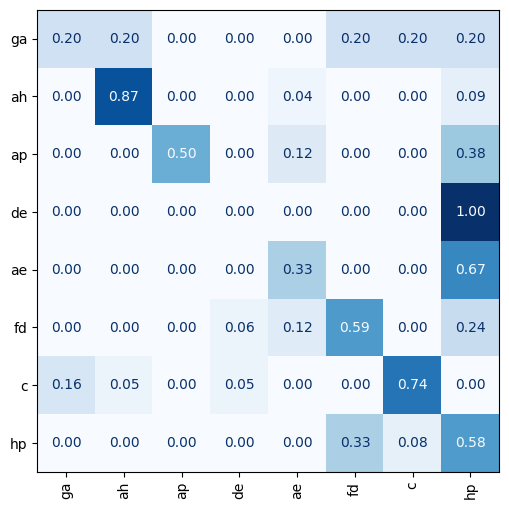

In [24]:
# E-8 (RoBERTa-BNE)

df = e8_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({
    'faulty generalization': 0, 
    'ad hominem': 1,
    'ad populum': 2,
    'deductive fallacy': 3,
    'appeal to emotion': 4,
    'false dilemma': 5,
    'fallacy of credibility': 6,
    'fallacy of extension': 7
})

dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=8)
f1, _, _ = run('roberta-bne-E8', dataset, modelo, evalua_weighted,"roberta_matrix_E8_bne.pdf", ["ga","ah","ap","de","ae","fd","c","hp"])
print("E8 RoBERTa-BNE")
print(f"F1: {f1}")

In [25]:
# E-5 (RoBERTa-BNE)

df = e5_df.rename(columns={"label": "labels"})
df['labels'] = df['labels'].replace({
    'ad hominem': 0,
    'ad populum': 1,
    'false dilemma': 2,
    'fallacy of credibility': 3,
    'fallacy of extension': 4
})

dataset = Dataset.from_pandas(df)
modelo = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=5)
f1, _, _ = run('roberta-bne-E5', dataset, modelo, evalua_weighted)
print("E5 RoBERTa-BNE")
print(f"F1: {f1}")

Epoch,Training Loss,Validation Loss,F1,P,R
1,No log,0.814212,0.667188,0.643006,0.700000
2,No log,0.779627,0.648293,0.670387,0.650000
3,No log,0.976233,0.688369,0.804660,0.700000
4,No log,0.893251,0.757470,0.807646,0.750000
5,No log,1.158652,0.738550,0.805280,0.725000
6,No log,1.162015,0.746259,0.811979,0.737500
7,No log,1.194289,0.746259,0.811979,0.737500
8,No log,1.208768,0.746259,0.811979,0.737500
9,No log,1.222910,0.746259,0.811979,0.737500
10,No log,1.224493,0.746259,0.811979,0.737500


E5 RoBERTa-BNE
F1: 0.7574700470688918
